In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from scipy.ndimage import convolve1d
import utils
import torch
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot




In [2]:
cols = ["fix_acidity", "vol_acidity", "critic_acidity", "res_sugar", "chloride", "free_SO2", "tot_SO2", "density", "pH","sulphate", "alcohol", "class"] # Quality is class

df = pd.read_csv("winequality-red.csv", names = cols, delimiter=";", header=0)


#df = df.loc[:, ['fix_acidity', 'vol_acidity', 'critic_acidity', 'alcohol','class']]




In [3]:
#change data type to value
data = df.values

In [4]:
#separating the X, y. They are the class and atributes and should be separated for the rest of the calculations.
X, y = data[:, :-1], data[:, -1]
scaler = StandardScaler()
X = scaler.fit_transform(X)







In [5]:
#we do necessary changes for the oversampling method SMOTE, since data is imbalanced.
y = LabelEncoder().fit_transform(y)

In [6]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)





In [7]:
counter = Counter(y)


Class=2, n=681 (16.667%)
Class=3, n=681 (16.667%)
Class=4, n=681 (16.667%)
Class=1, n=681 (16.667%)
Class=5, n=681 (16.667%)
Class=0, n=681 (16.667%)


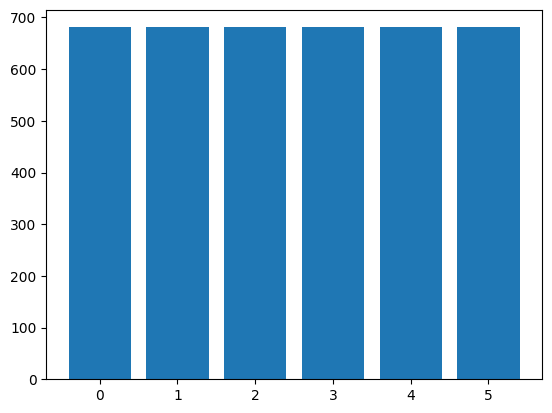

In [8]:
#the data becomes balanced, we just have the class from 3 to 8 available data.
#This data is shown by 0 to 5 (6 classes) in the x-axis, y-axis number of instances

for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [9]:
y.shape

(4086,)

In [10]:
X

array([[-0.52835961,  0.96187667, -1.39147228, ...,  1.28864292,
        -0.57920652, -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228, ..., -0.7199333 ,
         0.1289504 , -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, ..., -0.33117661,
        -0.04808883, -0.58477711],
       ...,
       [-1.59909712,  0.51927818, -1.20011386, ...,  1.36506949,
         0.95513348,  2.98256802],
       [-0.61134638, -0.85683275,  0.1861276 , ..., -0.50755641,
         0.50269691,  0.84930665],
       [ 1.29892784, -0.69090177,  1.23616918, ..., -0.54372858,
         0.73995115,  2.2541353 ]])

In [11]:
import matplotlib.pyplot as plt


In [12]:
#we start the neural network method
#encode to numpy array


from keras.utils import np_utils


encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

print(encoded_Y)

[2 2 2 ... 5 5 5]


In [13]:
#optimizer can be Adam 
#loss function should be categorical_crossentropy
#EarlyStopping callbacks to prevent overfitting

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [14]:
#######
#######
####### We convert back the oversampled data to dataframe to devide it to test and train sample
X = pd.DataFrame(X)
y = pd.DataFrame(y)

df = pd.concat([X, y], axis=1)

train, test = np.split(df.sample(frac = 1), [int(0.8*len(df))])


data = train.values
X, y = data[:, :-1], data[:, -1]
dummy_y = np_utils.to_categorical(y)
dummy_y






array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [15]:
#Neural network model contain two layers of 10 and 6 neurons
#

model = Sequential()
model.add(Dense(100, input_shape=(X.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(50, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(20, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(12, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])

Metal device set to: Apple M1


2022-11-17 00:43:47.070295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 00:43:47.071209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dense_3 (Dense)             (None, 12)                252       
                                                                 
 dense_4 (Dense)             (None, 6)                 78        
                                                                 
Total params: 7,600
Trainable params: 7,600
Non-trainable params: 0
_________________________________________________________________


In [16]:
#imply learning

import keras
from keras.callbacks import EarlyStopping

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(X,
                    dummy_y,
                    callbacks=[es],
                    epochs=800000, # you can set this to a big number!
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/800000


2022-11-17 00:44:28.989414: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-17 00:44:29.248212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


262/262 [==============================] - ETA: 0s - loss: 1.4192 - accuracy: 0.4155

2022-11-17 00:44:34.948801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


262/262 [==============================] - 6s 15ms/step - loss: 1.4192 - accuracy: 0.4155 - val_loss: 1.1548 - val_accuracy: 0.5168
Epoch 2/800000
262/262 [==============================] - 3s 13ms/step - loss: 1.0175 - accuracy: 0.5811 - val_loss: 0.9778 - val_accuracy: 0.5795
Epoch 3/800000
262/262 [==============================] - 3s 13ms/step - loss: 0.8937 - accuracy: 0.6500 - val_loss: 0.9558 - val_accuracy: 0.5917
Epoch 4/800000
262/262 [==============================] - 3s 13ms/step - loss: 0.8161 - accuracy: 0.6863 - val_loss: 0.8012 - val_accuracy: 0.6774
Epoch 5/800000
262/262 [==============================] - 3s 13ms/step - loss: 0.7538 - accuracy: 0.7154 - val_loss: 0.7397 - val_accuracy: 0.6957
Epoch 6/800000
262/262 [==============================] - 4s 14ms/step - loss: 0.7048 - accuracy: 0.7341 - val_loss: 0.6936 - val_accuracy: 0.7217
Epoch 7/800000
262/262 [==============================] - 3s 13ms/step - loss: 0.6682 - accuracy: 0.7402 - val_loss: 0.6777 - val_acc

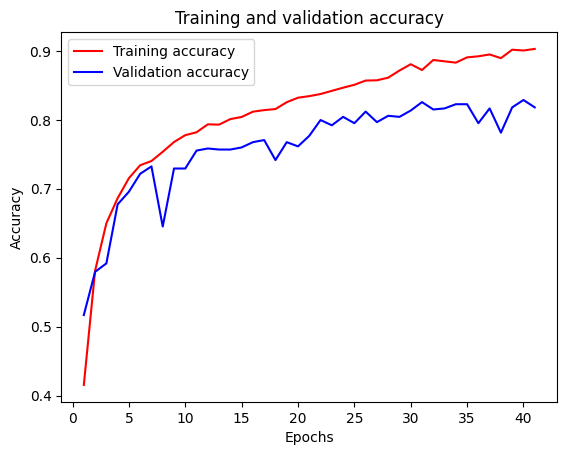

In [17]:
#check the train and test

import matplotlib.pyplot as plt

history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
#Change X and y to the test



from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

data = test.values
X, y = data[:, :-1], data[:, -1]
dummy_y = np_utils.to_categorical(y)
dummy_y


array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [19]:
#detail info, need to be studied

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report




preds = model.predict(X) # see how the model did!
print(preds[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1
## [9.9999988e-01 1.3509347e-07 6.7064638e-16]
## 1.0

# Almost a perfect prediction
# actual is left, predicted is top
# names can be found by inspecting Y
matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))
matrix
## array([[50,  0,  0],
##        [ 0, 46,  4],
##        [ 0,  1, 49]])


# more detail on how well things were predicted
print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))

 1/26 [>.............................] - ETA: 6s

2022-11-17 00:49:11.134794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 0s 3ms/step
[2.4791766e-12 8.4944572e-03 9.4523883e-01 4.6259731e-02 6.9401003e-06
 6.6992895e-16]
0.9999999
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       142
           1       0.91      0.95      0.93       140
           2       0.55      0.72      0.62       134
           3       0.66      0.41      0.50       145
           4       0.81      0.82      0.81       130
           5       0.95      1.00      0.98       127

    accuracy                           0.81       818
   macro avg       0.81      0.81      0.81       818
weighted avg       0.81      0.81      0.80       818

